# Autoencoder using CNN for MNIST

## Install dependencies

In [1]:
from typing import Tuple
from functools import partial
from itertools import islice

import jax
import jax.numpy as jnp
import numpy as np

try:
    import tensorflow as tf
except ModuleNotFoundError:
    # flax.training.checkpoints depends on tensorflow,
    # which is only installed by default on Colab
    %pip install -qq tensorflow-cpu
    import tensorflow as tf

tf.config.set_visible_devices([], "GPU")  # prevent TensorFlow from using the GPU

try:
    import flax
except ModuleNotFoundError:
    %pip install -qq flax
    import flax
import flax.linen as nn
from flax.training import train_state, checkpoints

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    from torchvision.datasets import MNIST
except ModuleNotFoundError:
    %pip install -qq torchvision
    from torchvision.datasets import MNIST

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

     |████████████████████████████████| 197 kB 35.4 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 140 kB 72.2 MB/s 
     |████████████████████████████████| 217 kB 74.3 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
     |████████████████████████████████| 72 kB 563 kB/s 


## Model Definition

In [2]:
class TrainState(train_state.TrainState):
    batch_stats: flax.core.FrozenDict[str, jnp.ndarray]


class Encoder(nn.Module):
    embedding_dim: int

    @nn.compact
    def __call__(self, X, training):
        X = nn.Conv(8, (3, 3), strides=2, padding=1)(X)
        X = jax.nn.relu(X)
        X = nn.Conv(16, (3, 3), strides=2, padding=1)(X)
        X = nn.BatchNorm(use_running_average=not training)(X)
        X = jax.nn.relu(X)
        X = nn.Conv(32, (3, 3), strides=2, padding=0)(X)
        X = jax.nn.relu(X)

        X = X.reshape((-1, np.prod(X.shape[-3:])))

        X = nn.Dense(128)(X)
        X = jax.nn.relu(X)
        X = nn.Dense(self.embedding_dim)(X)

        return X


class Decoder(nn.Module):
    output_dim: Tuple[int, int, int]

    @nn.compact
    def __call__(self, X, training):
        H, W, _ = self.output_dim
        H, W = H - 25, W - 25  # subtract 25 due to convolution

        X = nn.Dense(128)(X)
        X = jax.nn.relu(X)
        X = nn.Dense(H * W * 32)(X)
        X = jax.nn.relu(X)

        X = X.reshape((-1, H, W, 32))

        # NOTE: I am not sure if this is an word-to-word translation from PyTorch.
        # See https://flax.readthedocs.io/en/latest/howtos/convert_pytorch_to_flax.html#transposed-convolutions
        # However, the shape of activations and parameters match between PyTorch and Flax.
        X = nn.ConvTranspose(16, (3, 3), strides=(2, 2), padding=2)(X)
        X = nn.BatchNorm(use_running_average=not training)(X)
        X = jax.nn.relu(X)
        X = nn.ConvTranspose(8, (3, 3), strides=(2, 2), padding=((1, 2), (1, 2)))(X)
        X = nn.BatchNorm(use_running_average=not training)(X)
        X = jax.nn.relu(X)
        X = nn.ConvTranspose(1, (3, 3), strides=(2, 2), padding=((1, 2), (1, 2)))(X)
        X = jax.nn.sigmoid(X)

        return X


class AutoEncoder(nn.Module):
    embedding_dim: int
    output_dim: Tuple[int, int, int]

    def setup(self):
        self.encoder = Encoder(self.embedding_dim)
        self.decoder = Decoder(self.output_dim)

    def __call__(self, X, training):
        embedding = self.encoder(X, training)
        X = self.decoder(embedding, training)
        return embedding, X


def create_train_state(key, embedding_dim, learning_rate, specimen):
    ae = AutoEncoder(embedding_dim, specimen.shape)
    variables = ae.init(key, specimen, True)
    tx = optax.adam(learning_rate)
    state = TrainState.create(
        apply_fn=ae.apply,
        params=variables["params"],
        tx=tx,
        batch_stats=variables["batch_stats"],
    )

    return state

## Training/evaluation functions

In [3]:
@jax.jit
def train_step(state, image):
    @partial(jax.value_and_grad, has_aux=True)
    def loss_fn(params):
        variables = {"params": params, "batch_stats": state.batch_stats}
        (_, reconstructed), new_model_state = state.apply_fn(variables, image, True, mutable=["batch_stats"])
        loss = jnp.sum((reconstructed - image) ** 2)
        return loss.sum(), new_model_state

    (loss, new_model_state), grads = loss_fn(state.params)

    state = state.apply_gradients(grads=grads, batch_stats=new_model_state["batch_stats"])

    return state, loss


@jax.jit
def test_step(state, image):
    variables = {"params": state.params, "batch_stats": state.batch_stats}
    embedding, reconstructed = state.apply_fn(variables, image, False)

    return embedding, reconstructed

## Hyperparameters

In [4]:
epochs = 4
batch_size = 64
embedding_dim = 16
lr = 1e-2

key = jax.random.PRNGKey(42)
specimen = jnp.empty((28, 28, 1))
state = create_train_state(key, embedding_dim, lr, specimen)

# Download the MNIST dataset to root
train_dataset = MNIST("/tmp", train=True, download=True, transform=np.array)
test_dataset = MNIST("/tmp", train=False, download=True, transform=np.array)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw



## Training loop

In [5]:
train_loader = DataLoader(train_dataset, batch_size)

for epoch in range(epochs):
    train_loss = 0
    for X, _ in train_loader:
        image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0
        state, loss = train_step(state, image)
        train_loss += loss

    print(f"Epoch {epoch}: train loss {train_loss}")

Epoch 0: train loss 1924728.125
Epoch 1: train loss 921209.6875
Epoch 2: train loss 708391.1875
Epoch 3: train loss 621599.8125


## Visualization of reconstructed images

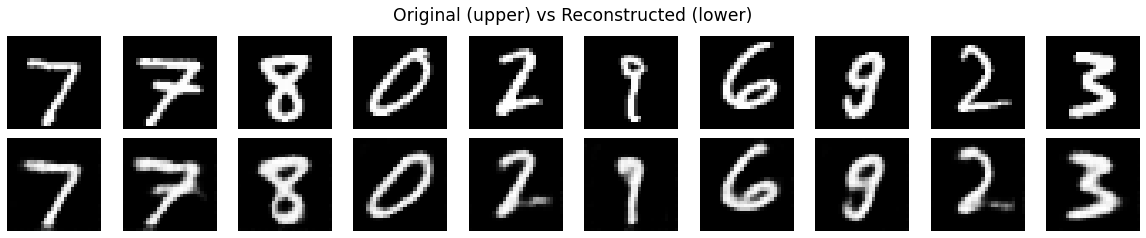

In [6]:
fig, axes = plt.subplots(2, 10, constrained_layout=True, figsize=plt.figaspect(0.2))

embeddings = []
labels = []

test_loader = DataLoader(test_dataset, batch_size)
for i, (X, y) in enumerate(islice(test_loader, 10)):
    image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0
    embedding, reconstructed = test_step(state, image)
    embeddings.append(embedding)
    labels.append(jnp.array(y))

    ax_orig, ax_reco = axes[0, i], axes[1, i]
    ax_orig.imshow(image[0].reshape(28, 28), cmap="gist_gray")
    ax_reco.imshow(reconstructed[0].reshape(28, 28), cmap="gist_gray")
    for j in range(2):
        axes[j, i].axis("off")

embeddings = jnp.concatenate(embeddings)
labels = jnp.concatenate(labels)

fig.suptitle("Original (upper) vs Reconstructed (lower)", fontsize="xx-large")
fig.show()

## Visualization of latent space with t-SNE

In [7]:
tsne = TSNE(
    perplexity=50,
    init="random",
    learning_rate="auto",
    random_state=42,
)
projections = tsne.fit_transform(embeddings, labels)

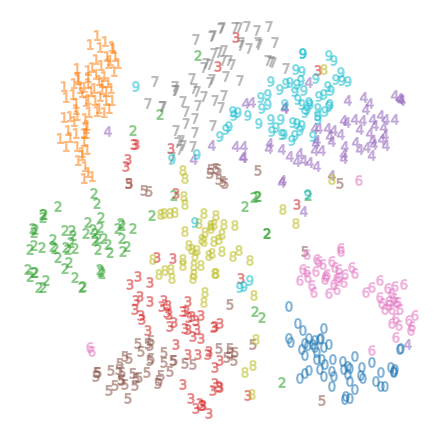

In [8]:
def plot_embeddings(X):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 6))
    for digit in range(10):
        ax.scatter(
            *X[labels == digit].T,
            marker=f"${digit}$",
            s=100,
            color=plt.cm.tab10(digit),
            alpha=0.4,
        )
    ax.axis("off")
    fig.show()


plot_embeddings(projections)